# Cargue de Datos

In [2]:
import pandas as pd

#df = pd.read_csv("hf://datasets/USC-MOLA-Lab/MFRC/final_mfrc_data.csv")
df = pd.read_excel('translated_texts_with_binary_fixed.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13080 entries, 0 to 13079
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   annotation_binary  13080 non-null  int64 
 1   text               13080 non-null  object
 2   translated_text    13080 non-null  object
dtypes: int64(1), object(2)
memory usage: 306.7+ KB


In [3]:
df.head()

,annotation_binary,text,translated_text
0,1,"/r/france is pretty lively, with it's own ling...","/r/france es bastante animado, con su propia j..."
1,1,it really is a very unusual situation isn't it...,"Es una situación muy inusual, pero Fillon tamb..."
2,1,The Le Pen brand of conservatism and classical...,La marca Le Pen del conservadurismo y el conse...
3,1,"Macrons face just screams\n""I do not know her,...","La cara de Macrons simplemente grita ""¡No la c..."
4,1,"Clinton lead polls by 4%, well within a reason...","Clinton lidera las encuestas en un 4%, bien de..."


# Textometría Básica

In [4]:
df.translated_text.str.len().describe()

count    13080.000000
mean       204.281193
std        140.436518
min         15.000000
25%         96.000000
50%        159.000000
75%        278.000000
max       1019.000000
Name: translated_text, dtype: float64

Máximo 1019 caracteres, en promedio 204

In [66]:
import nltk
import spacy
from nltk.corpus import stopwords

# Descargar las stopwords de NLTK
nltk.download('stopwords')

# Descargar el tokenizador de NLTK
nltk.download('punkt')

# Descargar el modelo de spaCy
nlp = spacy.load('es_core_news_sm')

# Aumentar la longitud máxima de procesamiento de spaCy
nlp.max_length = 2000000

def procesar_texto(texto):
    """
    Procesa el texto aplicando lematización y eliminando stopwords.

    Parámetro:
    - texto: String con el texto a procesar.

    Retorna:
    - Un string procesado.
    """
    # Procesar el texto con spaCy
    doc = nlp(texto.lower())
    # Filtrar y lematizar palabras que no sean stopwords ni puntuación
    palabras = [token.lemma_ for token in doc if token.lemma_ not in stopwords.words('spanish') and token.is_alpha]
    return palabras




[nltk_data] Downloading package stopwords to /Users/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/luis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


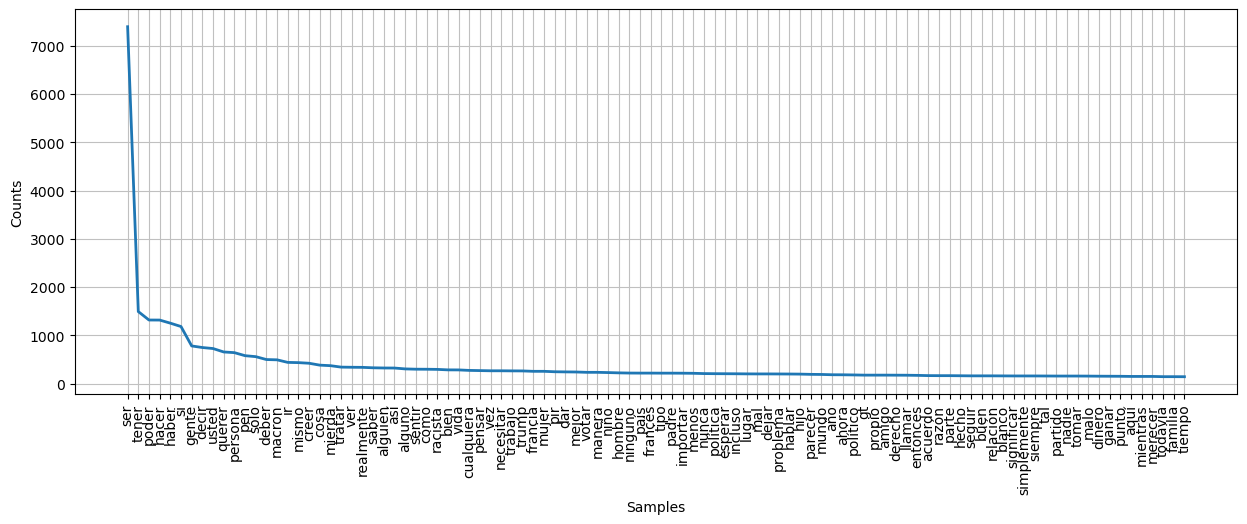

<Figure size 640x480 with 0 Axes>

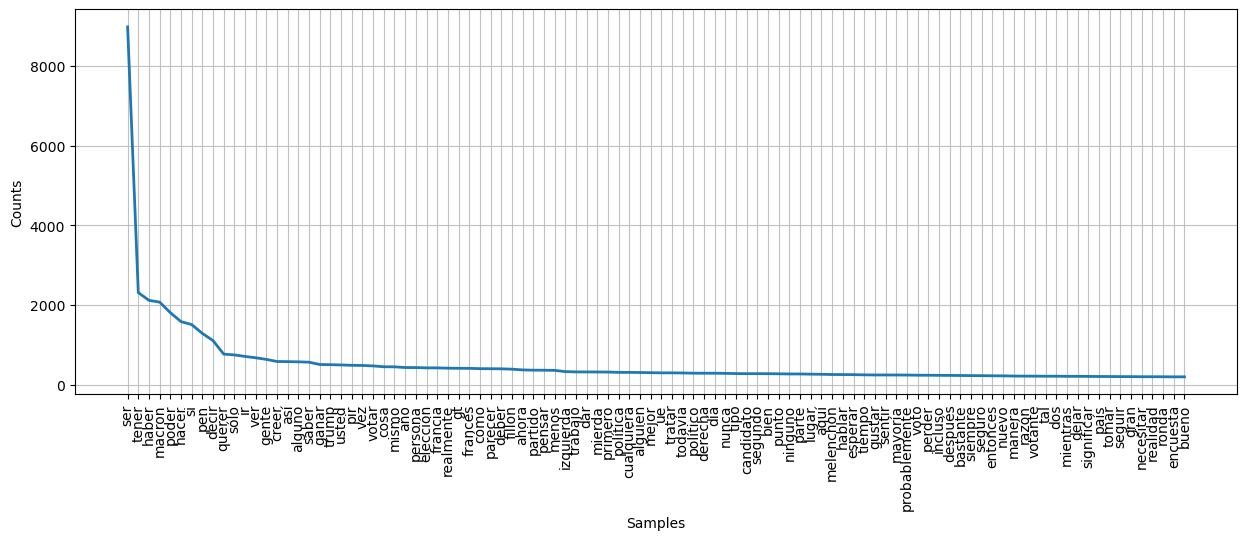

<Figure size 640x480 with 0 Axes>

In [74]:
from nltk import FreqDist

texto_moral = " ".join(df[df.annotation_binary == 0].translated_text.dropna().tolist())
texto_moral = procesar_texto(texto_moral)

texto_no_moral = " ".join(df[df.annotation_binary == 1].translated_text.dropna().tolist())
texto_no_moral = procesar_texto(texto_no_moral)


fig = plt.figure(figsize=(15, 5))
FreqDist(texto_moral).plot(100)
plt.savefig('images/moral_freqdist.png')

fig = plt.figure(figsize=(15, 5))
FreqDist(texto_no_moral).plot(100)
plt.savefig('images/no_moral_freqdist.png')

In [73]:
import nltk.collocations
from nltk import bigrams

moral_bigrams = list(bigrams(texto_moral))
no_moral_bigrams = list(bigrams(texto_no_moral))

print(moral_bigrams[0:10])
print(no_moral_bigrams[0:10])



[('france', 'ser'), ('ser', 'bastante'), ('bastante', 'animado'), ('animado', 'propio'), ('propio', 'jerga'), ('jerga', 'soler'), ('soler', 'ser'), ('ser', 'deliberadamente'), ('deliberadamente', 'mala'), ('mala', 'traducción')]
[('izquierdista', 'nunca'), ('nunca', 'apoyarer'), ('apoyarer', 'pir'), ('pir', 'especialmente'), ('especialmente', 'tener'), ('tener', 'cuenta'), ('cuenta', 'extraño'), ('extraño', 'fobio'), ('fobio', 'judío'), ('judío', 'usted')]


# Wordclouds

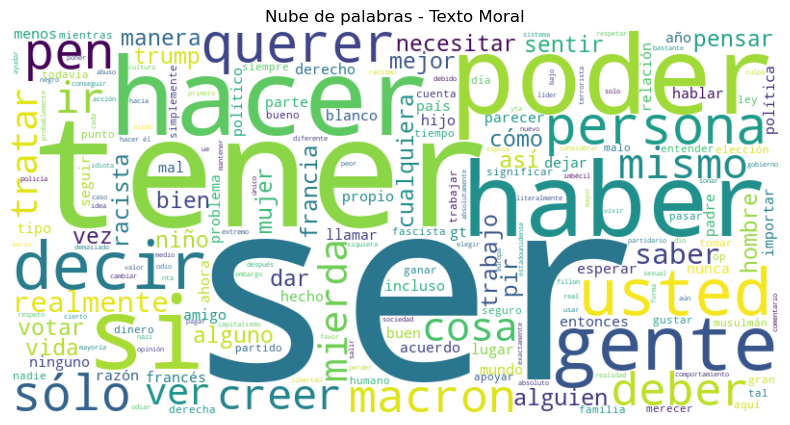

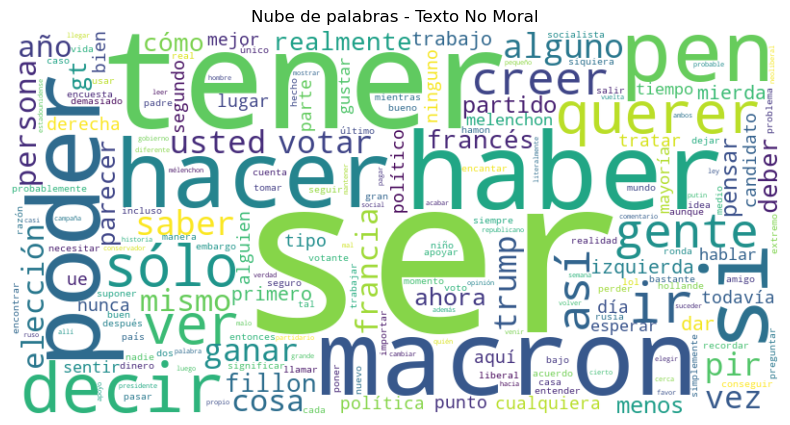

In [77]:
import matplotlib.pyplot as plt
from nltk import FreqDist
from wordcloud import WordCloud

# Clase 0
wordcloud_clase_0 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(FreqDist(texto_moral))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_clase_0, interpolation='bilinear')
plt.title("Nube de palabras - Texto Moral")
plt.axis('off')
plt.savefig('images/moral_wordcloud.png')
plt.show()

# Clase 1
wordcloud_clase_1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(FreqDist(texto_no_moral))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_clase_1, interpolation='bilinear')
plt.title("Nube de palabras - Texto No Moral")
plt.axis('off')
plt.savefig('images/no_moral_wordcloud.png')
plt.show()



# Diversidad Lexica


In [80]:
from typing import List

def type_token_ratio(tokens: List[str]) -> float:
    """
    Calculate the Type-Token Ratio (TTR) for a given list of tokens.
    
    TTR is a measure of lexical diversity calculated as the ratio of unique words
    to the total number of words in a text.
    
    Args:
    tokens (List[str]): A list of tokens (words) from the text.
    
    Returns:
    float: The Type-Token Ratio.
    """
    # Calculate unique words and total words
    unique_words = len(set(tokens))
    total_words = len(tokens)
    
    # Avoid division by zero
    if total_words == 0:
        return 0
    
    # Calculate and return TTR
    return unique_words / total_words

print(f"TTR Moral: {type_token_ratio(texto_moral)}")
print(f"TTR No Moral: {type_token_ratio(texto_no_moral)}")



TTR Moral: 0.1041589621085668
TTR No Moral: 0.10454067704549141


# Creación del Clasificador

## División de los datos

In [83]:
from sklearn.model_selection import train_test_split
import numpy as np

# Crear un vectorizador de texto
vectorizer = CountVectorizer(tokenizer=procesar_texto)

X_train, X_test, y_train, y_test = train_test_split(df.translated_text, df.annotation_binary, test_size=0.3, random_state=42, stratify=df.annotation_binary)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

df['data_split'] = np.where(df.index.isin(X_test.index), 'test', 
                   np.where(df.index.isin(X_val.index), 'val', 'train'))

df[['translated_text', 'annotation_binary', 'data_split']].to_csv('data_split.csv', index=False)


In [88]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

vectorizers = [CountVectorizer(tokenizer=procesar_texto), 
                TfidfVectorizer(tokenizer=procesar_texto)]

classifiers = [MultinomialNB(), 
              LogisticRegression(max_iter=200), 
              LinearSVC(), 
              RandomForestClassifier()]

for vectorizer in vectorizers:
    vectorizer.fit(X_train)
    for classifier in classifiers:
        classifier.fit(vectorizer.transform(X_train), y_train)
        y_pred = classifier.predict(vectorizer.transform(X_test))
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Vectorizer: {vectorizer.__class__.__name__}, Classifier: {classifier.__class__.__name__}, Accuracy: {accuracy}\n")
        print(classification_report(y_test, y_pred))
        print("-----------------------------------\n")



/opt/anaconda3/envs/nlp_course/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorizer: CountVectorizer, Classifier: MultinomialNB, Accuracy: 0.7879714576962283

              precision    recall  f1-score   support

           0       0.67      0.72      0.70       661
           1       0.85      0.82      0.84      1301

    accuracy                           0.79      1962
   macro avg       0.76      0.77      0.77      1962
weighted avg       0.79      0.79      0.79      1962

-----------------------------------

Vectorizer: CountVectorizer, Classifier: LogisticRegression, Accuracy: 0.8144750254841998

              precision    recall  f1-score   support

           0       0.79      0.62      0.69       661
           1       0.83      0.91      0.87      1301

    accuracy                           0.81      1962
   macro avg       0.81      0.77      0.78      1962
weighted avg       0.81      0.81      0.81      1962

-----------------------------------

Vectorizer: CountVectorizer, Classifier: LinearSVC, Accuracy: 0.7823649337410805

             

/opt/anaconda3/envs/nlp_course/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorizer: TfidfVectorizer, Classifier: MultinomialNB, Accuracy: 0.7528032619775739

              precision    recall  f1-score   support

           0       0.87      0.31      0.46       661
           1       0.74      0.98      0.84      1301

    accuracy                           0.75      1962
   macro avg       0.80      0.64      0.65      1962
weighted avg       0.78      0.75      0.71      1962

-----------------------------------

Vectorizer: TfidfVectorizer, Classifier: LogisticRegression, Accuracy: 0.8027522935779816

              precision    recall  f1-score   support

           0       0.80      0.55      0.65       661
           1       0.80      0.93      0.86      1301

    accuracy                           0.80      1962
   macro avg       0.80      0.74      0.76      1962
weighted avg       0.80      0.80      0.79      1962

-----------------------------------

Vectorizer: TfidfVectorizer, Classifier: LinearSVC, Accuracy: 0.8124362895005097

             